In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection import KFold

In [13]:
reader = Reader(sep=',', rating_scale=(0.0, 5.0), skip_lines=1)
df = pd.read_csv('ml-latest-small/ratings.csv', names = ['userId', 'itemId', 'rating', 'timestamp'],header=0)
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'itemId', 'rating']], reader)

# Questions 17-18: NNMF Collaborative Filter

In [14]:
def model_Error_Sweep(data, plotName, biased = False, ks = range(2, 52, 2), cv=10):
    mae, rmse = [0] * len(ks), [0] * len(ks)
    for i, k in enumerate(ks):
        model = NMF(n_factors=k, biased=False)
        scores = cross_validate(model, data, cv=cv, n_jobs=-1)
        mae[i] = scores['test_mae'].mean()
        rmse[i] = scores['test_rmse'].mean()
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(ks, mae)
    plt.title('Mean Absolute Error (MAE) vs. k of ' + plotName)
    plt.xlabel('k')
    plt.ylabel('MAE')
    plt.subplot(2, 1, 2)
    plt.plot(ks, rmse)
    plt.title('Root Mean Squared Error (RMSE) vs. k of ' + plotName)
    plt.xlabel('k')
    plt.ylabel('RMSE')
    return ks, mae, rmse


For NNMF model:
Min RSME: 0.9132966691349413 at k = 18
Min MAE: 0.6940245376059052 at k = 22


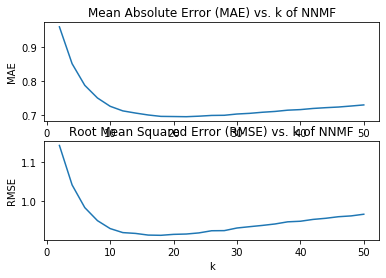

In [15]:
[ks_NNMF, mae_NNMF, rmse_NNMF] = model_Error_Sweep(data, "NNMF", ks = range(2, 52, 2), cv=10)
print('For NNMF model:')
print('Min RSME: {} at k = {}'.format(np.min(rmse_NNMF), ks_NNMF[np.argmin(rmse_NNMF)]))
print('Min MAE: {} at k = {}'.format(np.min(mae_NNMF), ks_NNMF[np.argmin(mae_NNMF)]))

In [16]:
def GetDataframe():
#     df = pd.read_csv("C:/Users/AJ/Desktop/ml-latest-small/ratings.csv")
    df = pd.read_csv("ml-latest-small/ratings.csv")
    df.drop('timestamp', axis=1, inplace=True)
    num_users = df.userId.unique().shape[0]
    num_items = df.movieId.unique().shape[0]

    print('Number of users: %d, number of items: %d.' % (num_users, num_items))
    return df, num_users, num_items

def GetRMatrix(data):
    X = data.values
    users = X[:,0]
    movies = X[:,1]

    movie_map = {}
    reverse_movie_map = {}
    new_id = 0
    for idx in range(len(movies)):
        item = int(movies[idx])
        if item not in movie_map:
            movie_map[item] = new_id
            reverse_movie_map[new_id] = item
            new_id += 1

    ratings = X[:,2]
    num_ratings = int(len(ratings))
    R = np.zeros((num_users, num_items))

    for i in np.arange(num_ratings):
        R[int(users[i]-1), movie_map[movies[i]]] = ratings[i]
        
    return R, users, movies, ratings, movie_map, reverse_movie_map

df, num_users, num_items = GetDataframe()
R, users, movies, ratings, movie_map, reverse_movie_map = GetRMatrix(df)

Number of users: 610, number of items: 9724.


# Questions 19: NNMF Filter with Popular Movie Trimming

In [ ]:
def GetMovieStats(R):
    is_rated = R!=0
    rat_per_movie = np.sum(is_rated, axis=0)

    nanR = R.copy()
    nanR[nanR == 0] = np.nan
    var_per_movie = np.nanvar(nanR, axis=0)
    return rat_per_movie, var_per_movie

def TrimPopular(testset, rat_per_movie, movie_map):
    res = []
    for item in testset:
        if rat_per_movie[movie_map[item[1]]] > 2:
            res.append(item)
            
    return res

def TrimUnpopular(testset, rat_per_movie, movie_map):
    res = []
    for item in testset:
        if rat_per_movie[movie_map[item[1]]] <= 2:
            res.append(item)
            
    return res

def TrimVariance(testset, rat_per_movie, var_per_movie, movie_map):
    res = []
    for item in testset:
        if rat_per_movie[movie_map[item[1]]] >= 5 and var_per_movie[movie_map[item[1]]] >= 2:
            res.append(item)
            
    return res


def GetTrimResults(model_func, data, R):
    rat_per_movie, var_per_movie = GetMovieStats(R)

    kf = KFold(n_splits=10)

    ks = np.arange(2, 102, 2)
    rmse = np.zeros((len(ks), 3))
    for idx, k in enumerate(ks):
        algo = model_func(k)

        for trainset, testset in kf.split(data):
            algo.fit(trainset)

            popular_testset = TrimPopular(testset, rat_per_movie, movie_map)
            unpopular_testset = TrimUnpopular(testset, rat_per_movie, movie_map)
            var_testset = TrimVariance(testset, rat_per_movie, var_per_movie, movie_map)

            predictions = algo.test(popular_testset)
            rmse[idx, 0] += accuracy.rmse(predictions, verbose=False)

            predictions = algo.test(unpopular_testset)
            rmse[idx, 1] += accuracy.rmse(predictions, verbose=False)

            predictions = algo.test(var_testset)
            rmse[idx, 2] += accuracy.rmse(predictions, verbose=False)

    rmse /= 10

    test_names = ["popular", "unpopular", "high variance"]
    for i in range(3):
        plt.plot(ks, rmse[:, i])
        plt.title("RMSE vs k for {} testset".format(test_names[i]))
        plt.ylabel("RMSE")
        plt.xlabel("k")
        plt.show()

model_func = lambda x : NMF(n_factors=x, biased=False)
GetTrimResults(model_func, data, R)

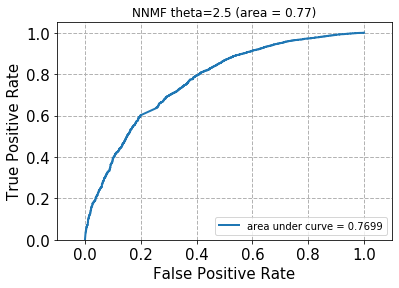

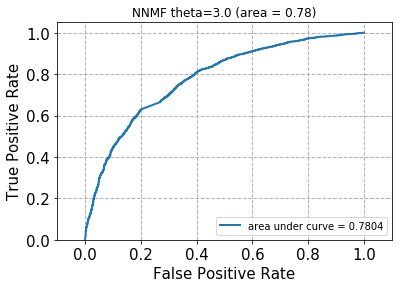

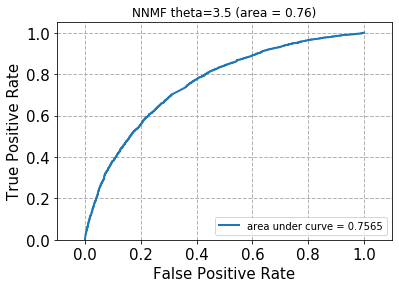

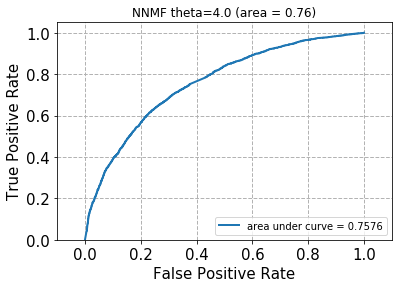

In [117]:
from sklearn import metrics
bestLF = 20
thresholds = [2.5, 3, 3.5, 4]
df = pd.read_csv('ml-latest-small/ratings.csv', names = ['userId', 'itemId', 'rating', 'timestamp'],header=0)
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'itemId', 'rating']], reader)
NNMF_threshold_3_fpr = None
NNMF_threshold_3_tpr = None
for threshold in thresholds:
    train_set, test_set = train_test_split(data, test_size=0.1)
    algo = NMF(n_factors=bestLF, biased=False)
    algo.fit(train_set)
    predictions = algo.test(test_set)
    trues = [0 if getattr(row, 'r_ui') < threshold else 1 for row in predictions]
    scores = [getattr(row, 'est') for row in predictions]
    fpr, tpr, _ = metrics.roc_curve(trues, scores)
    if threshold == 3:
        NNMF_threshold_3_fpr = fpr
        NNMF_threshold_3_tpr = tpr
    roc_auc = metrics.auc(fpr, tpr)
    name = 'NNMF thershold = %.1f (area = %0.2f)' % (threshold, roc_auc)
    plot_roc(fpr,tpr, name)

# Questions 24-25: MF Collaborative Filter

In [ ]:
def model_Error_Sweep2(data, plotName, biased = False, ks = range(2, 52, 2), cv=10):
    mae, rmse = [0] * len(ks), [0] * len(ks)
    for i, k in enumerate(ks):
        model = SVD(n_factors=k, biased=False)
        scores = cross_validate(model, data, cv=cv, n_jobs=-1)
        mae[i] = scores['test_mae'].mean()
        rmse[i] = scores['test_rmse'].mean()
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(ks, mae)
    plt.title('Mean Absolute Error (MAE) vs. k of ' + plotName)
    plt.xlabel('k')
    plt.ylabel('MAE')
    plt.subplot(2, 1, 2)
    plt.plot(ks, rmse)
    plt.title('Root Mean Squared Error (RMSE) vs. k of ' + plotName)
    plt.xlabel('k')
    plt.ylabel('RMSE')
    return ks, mae, rmse

In [ ]:
[ks_SVD, mae_SVD, rmse_SVD] = model_Error_Sweep2(data, "SVD", biased = True, ks = range(2, 52, 2), cv=10)
print('For NNMF model:')
print('Min RSME: {} at k = {}'.format(np.min(rmse_NNMF), ks_NNMF[np.argmin(rmse_NNMF)]))
print('Min MAE: {} at k = {}'.format(np.min(mae_NNMF), ks_NNMF[np.argmin(mae_NNMF)]))

In [ ]:
model_func = lambda x : NMF(n_factors=x, biased=False)
GetTrimResults(model_func, data, R)

In [ ]:
bestLF = 20
thresholds = [2.5, 3, 3.5, 4]
df = pd.read_csv('ml-latest-small/ratings.csv', names = ['userId', 'itemId', 'rating', 'timestamp'],header=0)
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'itemId', 'rating']], reader)
NNMF_threshold_3_fpr = None
NNMF_threshold_3_tpr = None
for threshold in thresholds:
    train_set, test_set = train_test_split(data, test_size=0.1)
    algo = SVD(n_factors=bestLF, biased=True)
    algo.fit(train_set)
    predictions = algo.test(test_set)
    trues = [0 if getattr(row, 'r_ui') < threshold else 1 for row in predictions]
    scores = [getattr(row, 'est') for row in predictions]
    fpr, tpr, _ = metrics.roc_curve(trues, scores)
    if threshold == 3:
        NNMF_threshold_3_fpr = fpr
        NNMF_threshold_3_tpr = tpr
    roc_auc = metrics.auc(fpr, tpr)
    name = 'NNMF thershold = %.1f (area = %0.2f)' % (threshold, roc_auc)
    plot_roc(fpr,tpr, name)